In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import re
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk
import matplotlib.pyplot as plt
import numpy as np

In [63]:
import tmdbsimple as tmdb
# get api key from tmdb_config.json
import json
with open('../tmdb_config.json') as f:
    config = json.load(f)
tmdb.API_KEY = config['TMDB_API_KEY']

In [64]:
mock_general_movies =[
    "Iron Man",
    "Ocean's Eleven",
    "finding nemo",
    "The Lord of the Rings: The Fellowship of the Ring",
    "Die Hard",
    "Marvel's The Avengers",
    "The Godfather",
    "The Shawshank Redemption",
    "Inside",
    "The Matrix",
    "Nightmare on Elm Street",
    "The Silence of the Lambs",
    "The Sixth Sense",
    "The Usual Suspects",
    "The Departed",
    "The Prestige",
    "The Dark Knight Rises",
    "The Jungle Book",
    "The Lion King",
    "Monsters Inc.",
    "Toy Story",
    "A Simple Favor",
    "Mama Mia",
    "The Notebook",
    "The Fault in Our Stars",
    "The Hunger Games",
    "My Big Fat Greek Wedding",
    "The Hangover",
    "The Proposal",
    "Bird Box",
    "Birdman",
    "The Shape of Water"
]

mock_horror_movies = ['The Shining', 
    'A Clockwork Orange', 
    'The Exorcist', 
    'The Sixth Sense', 
    'Poltergeist', 
    'The Omen', 
    'Psycho', 
    'The Birds', 
    'Halloween', 
    'The Amityville Horror', 
    'The Conjuring', 
    'Insidious', 
    'The Grudge', 
    'Sinister', 
    'Saw', 
    'The Texas Chainsaw Massacre', 
    'The Ring', 
    'The Blair Witch Project',
    'The Babadook',
      'The Conjuring 2', 
      'The Orphanage', 
      'The VVitch', 
      'It Follows', 
      'Get Out', 
      'Hereditary', 
      'Annihilation', 
]

# mock_movie_titles = mock_general_movies
mock_movie_titles = mock_horror_movies + mock_general_movies

# remove duplicates
mock_movie_titles = list(set(mock_movie_titles))

In [65]:
# get movie ids from movie titles
movie_ids = []
for title in mock_movie_titles:
    response = tmdb.Search().movie(query=title)
    movie_ids.append(response['results'][0]['id'])

In [66]:
# Find the director of a movie
def find_director(movie_id):
    movie_credits = tmdb.Movies(movie_id).credits()
    for crew_member in movie_credits['crew']:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return None
# print(find_director(movie_ids[0]))

In [67]:
# get movie details, we only need the overview, genres, release year, and director
movie_details = []
for movie in movie_ids[:]:
    
    details = tmdb.Movies(movie).info()
    
    # get genres, join them into a string
    genres = " ".join([genre['name'] for genre in details['genres']])

    # get synopsis, do some preprocessing
    overview = details['overview']
    overview = overview.lower()
    # use regex to remove all non-alphanumeric characters
    overview = re.sub(r'[^a-zA-Z0-9\s]', '', overview)

    # get release year
    release_year = int(details['release_date'].split("-")[0])
    
    # get director
    director = find_director(movie)

    # go to imbd for more information
    imdb_id = details['imdb_id']

    # append to movie_details
    movie_details.append({
        'id' : movie,
        'title': details['title'],
        'overview': overview,
        'genres': genres,
        'release_year': release_year,
        'director': director
    })

# convert to pandas dataframe
pandas_movie_details = pd.DataFrame(movie_details)

In [68]:
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_column(df, column_name):
    # tokenize the text
    df[column_name] = df[column_name].apply(lambda x: word_tokenize(x))
    # remove stop words
    df[column_name] = df[column_name].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    # stem the words
    df[column_name] = df[column_name].apply(lambda x: [stemmer.stem(word) for word in x])
    # join the words back into a string
    df[column_name] = df[column_name].apply(lambda x: " ".join(x))

# # print before
# print(pandas_movie_details['overview'][0])

stem_column(pandas_movie_details, 'overview')
stem_column(pandas_movie_details, 'genres')

# # print after
# print(pandas_movie_details['overview'][0])

In [69]:
# create a stemmer
stemmer = PorterStemmer()

# # stem the overview
stemmed_overview = []
for overview in pandas_movie_details['overview']:
    stemmed_overview.append(" ".join([stemmer.stem(word) for word in overview.split(" ")]))

# # stem the genres
stemmed_genres = []
for genres in pandas_movie_details['genres']:
    stemmed_genres.append(" ".join([stemmer.stem(word) for word in genres.split(" ")]))

# # update the dataframe with the stemmed text
# pandas_movie_details['overview'] = stemmed_overview
# pandas_movie_details['genres'] = stemmed_genres


In [70]:
# #post stemming
# print(pandas_movie_details['overview'][0])

In [73]:
# prepare the dataframe for clustering
df = pandas_movie_details.drop(columns=['id', 'title'])

# create a tfidf vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
# vectorize overview
overview_vectors = tfid_vectorizer.fit_transform(df['overview'])

# reduce dimensionality using PCA
num_components = 100
svd = TruncatedSVD(n_components=num_components, n_iter=10)
overview_vectors = svd.fit_transform(overview_vectors)

# vectorize director
# write a token pattern that grabs the full name of the director (may contain periods)
director_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii', token_pattern=r'[a-zA-Z.\s]+')
director_vectors = director_vectorizer.fit_transform(df['director'])

count_vectorizer = CountVectorizer(stop_words='english')
# vectorize genres
genre_vectors = count_vectorizer.fit_transform(df['genres'])

# combine all features 
combined_vectors = np.concatenate((overview_vectors, director_vectors.toarray(), genre_vectors.toarray()), axis=1)
# put into a dataframe
df_vectors = pd.DataFrame(combined_vectors)

# print the top 10 features after dimensionality reduction
top_c = svd.components_.argsort()[:, -num_components:]
print("Top synopsis features:")
print([tfid_vectorizer.get_feature_names_out()[i] for i in top_c[0]])

Top synopsis features:
['lurk', 'fall love', 'claim', 'famili patriarch', 'patriarch', 'make', 'corleon', 'crime famili', 'unravel', 'way', 'escal attack', 'famili suburban', 'youngest daughter', 'famili come', 'spirit terrifi', 'angri spirit', 'suburban home', 'come togeth', 'apparit escal', 'apparit', 'attack youngest', 'terrifi apparit', 'invad angri', 'suburban', 'togeth rescu', 'home invad', 'investig', 'attack', 'strang', 'rescu', 'fatal', 'monster', 'jay', 'hit', 'woman', 'escal', 'sleep', 'supernatur', 'pass', 'fear', 'confront', 'old', 'angri', 'stori', 'terror', 'secret', 'togeth', 'attempt', 'reach', 'desper', 'ellison', 'singl mother', 'singl', 'power', 'best', 'thing', 'lorrain', 'ed', 'man', 'youngest', 'world', 'crime', 'love', 'begin', 'becom', 'increasingli', 'film', 'person', 'death', 'forc', 'mother', 'new', 'daughter famili', 'mysteri', 'invad', 'fall', 'friend', 'dark', 'killer', 'hous', 'discov', 'work', 'children', 'learn', 'plagu', 'come', 'warren', 'young', 'pr

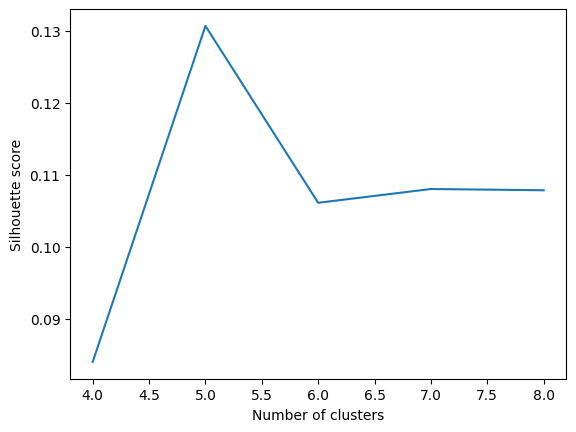

Cluster:  4
The Fault in Our Stars  -  222935
The Notebook  -  11036
The Lion King  -  8587
The Proposal  -  18240
The Shape of Water  -  399055
Birdman or (The Unexpected Virtue of Ignorance)  -  194662
My Big Fat Greek Wedding  -  8346

Cluster:  3
A Simple Favor  -  484247
Ocean's Eleven  -  161
American Psycho  -  1359
The Shawshank Redemption  -  278
The Godfather  -  238
The Dark Knight Rises  -  49026
The Departed  -  1422
The Sixth Sense  -  745
The Usual Suspects  -  629
The Silence of the Lambs  -  274
Die Hard  -  562

Cluster:  2
The Hunger Games: Mockingjay - Part 1  -  131631
Iron Man 2  -  10138
The Prestige  -  1124
The Avengers  -  24428
Bird Box  -  405774
The Matrix Resurrections  -  624860
Annihilation  -  300668
A Clockwork Orange  -  185

Cluster:  1
Finding Nemo  -  12
The Lord of the Rings: The Fellowship of the Ring  -  120
The Jungle Book  -  9325
Monsters, Inc.  -  585
Toy Story  -  862
Inside Out  -  150540
Mama Mia - Nur keine Panik  -  4659
The Hangover  -

In [74]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score for different values of n_clusters
scores = []
kmeans_models = {}
for n_clusters in range(4,9):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    clusters = kmeans.fit_predict(df_vectors)
    score = silhouette_score(df_vectors, clusters)
    scores.append(score)
    kmeans_models[score] = kmeans

# Plot the silhouette scores
plt.plot(range(4, 9), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# save n_clusters that maximizes the silhouette score
best_score = max(scores)
best_model = kmeans_models[best_score]

# add the labels, to the original dataframe
pandas_movie_details['cluster'] = best_model.labels_

# print each cluster and the movies in it
for cluster in pandas_movie_details['cluster'].unique():
    print("Cluster: ", cluster)
    titles = pandas_movie_details[pandas_movie_details['cluster'] == cluster]['title']
    ids = pandas_movie_details[pandas_movie_details['cluster'] == cluster]['id']
    for title, id in zip(titles, ids):
        print(title, " - ", id)
    print()